In [1]:
import os
import pandas as pd
import geopandas as gpd

### Inputs

#### Network

In [2]:
network_load_path = os.path.join('..', 'Source_Data', 'Model_Output', 'loaded_network.shp')
network_save_path = os.path.join('..', 'Data', 'Model_Output', 'loaded_network.shp')

#### Ridership

In [3]:
routes_path = os.path.join('..', 'Source_Data', 'Model_Output', 'Transit_network')

boards_load_path = os.path.join(routes_path, 'ALL_BOARDINGS.DBF')
ref_load_path = os.path.join(routes_path, 'route_ref_new.csv')

routes_load_path = os.path.join(routes_path, 'ChattaTransit_2019_route.shp')
routes_save_path = os.path.join('..', 'Data', 'Model_Output', 'ridership.shp')

dtypes = {'ROUTE_ID': 'str'}

#### Trips

In [4]:
taz_path = os.path.join('..', 'Source_Data', 'Districts_01252021', 'TAZ_districts_Ext.shp')
xref_path = os.path.join('..', 'Source_Data', 'Districts_01252021', 'xref_taz_ext.csv')

triptables_list = ['trip_tables', 'tranist_trip_tables_AM', 'tranist_trip_tables_PM', 'tranist_trip_tables_OP', 'Truck_OD']
triptable_load_path = os.path.join('..', 'Source_Data', 'Model_Output')
trips_save_path = os.path.join('..', 'Data', 'Model_Output', 'trips.shp')


### Define Functions

In [5]:
def load_trip_table(t, tloadpath):
    colnames = tt = list(pd.read_csv(os.path.join(tloadpath, f'{t}.dcc')).index.get_level_values(0))
    tt = pd.read_csv(os.path.join(tloadpath, f'{t}.csv'), names=colnames)
    
    return tt

### Load Data

#### Network

In [6]:
network = gpd.read_file(network_load_path)

#### Ridership

In [7]:
routes = gpd.read_file(routes_load_path, dtype=dtypes)
boards = gpd.read_file(boards_load_path, dtype=dtypes)
ref = gpd.read_file(ref_load_path, dtype=dtypes)

routes = routes[['ROUTE_ID', 'ROUTE_NAME', 'geometry']]
routes = routes.astype(dtypes)
ref = ref.astype(dtypes)

#### Trips

In [8]:
taz = gpd.read_file(taz_path)
# print(list(taz))
taz = taz[[
    'OBJECTID',
    'TAZ_Ext',
    'COUNTYID',
    'STATEID',
    'geometry'
]].copy()

tt = {}
for t in triptables_list:
    tt[t] = load_trip_table(t, triptable_load_path)

### Process Existing Conditions

#### Process Network Variables

<AxesSubplot:>

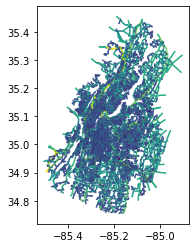

In [9]:
## Map12: AM Peak LOS (Volume/Capacity)
# network['AM_LOS'] = (network['AB_AM_TOTF']+network['BA_AM_TOTF'])/(network['AB_AMCAP']+network['BA_AMCAP'])
network['AM_LOS'] = network['AM_TOTFLOW'] / (network['AB_AMCAP'] + network['BA_AMCAP'])

## Map13: PM Peak LOS (Volume/Capacity)
# network['PM_LOS'] = (network['AB_PM_TOTF']+network['BA_PM_TOTF'])/(network['AB_PMCAP']+network['BA_PMCAP'])
network['PM_LOS'] = network['PM_TOTFLOW'] / (network['AB_PMCAP'] + network['BA_PMCAP'])

## Map14: VMT: Vehicle Miles Traveled
network['VMT'] = network['TOTFLOW'] * network['LENGTH']

## Map15: VHD: Vehicle hours of delay
# network['VHD'] = ((network['CTIME'] - network['FFTIME']) / 60) * network['TOTFLOW']
network['VHD'] = ((network['AB_CTIME'] - network['FFTIME']) * network['AB_TOTFLOW'] +
                  (network['BA_CTIME'] - network['FFTIME']) * network['BA_TOTFLOW']
                 )/60

## Map16: Congested speeds
## Calculate Congested Time
network.loc[network['DIR']==0, 'CTIME'] = (network['AB_CTIME'] + network['BA_CTIME']) / 2
network.loc[network['DIR'].isin([-1, 1]), 'CTIME'] = network[['AB_CTIME', 'BA_CTIME']].max(axis=1)
network['C_SPEED'] = network['LENGTH'] / (network['CTIME'] / 60)

network.plot('C_SPEED')

In [10]:
network[['AM_LOS', 'PM_LOS', 'VMT', 'VHD', 'C_SPEED', 'FFSPEED']].describe()

,AM_LOS,PM_LOS,VMT,VHD,C_SPEED,FFSPEED
count,38293.000000,38293.000000,38293.000000,38293.000000,38293.000000,38293.000000
mean,0.046411,0.058578,362.665669,2.720654,21.987459,29.490134
std,0.104490,0.125604,1927.572616,18.600309,13.300754,13.140606
min,0.000000,0.000000,0.000000,-0.000040,0.157996,20.000000
25%,0.000000,0.000000,0.000000,0.000000,13.438267,20.000000
50%,0.000000,0.000000,0.000000,0.000000,17.078939,20.000000
75%,0.025293,0.035678,120.182963,0.017003,30.849745,39.659496
max,1.116131,1.162090,102236.249752,876.776432,73.250013,73.250000


<AxesSubplot:>

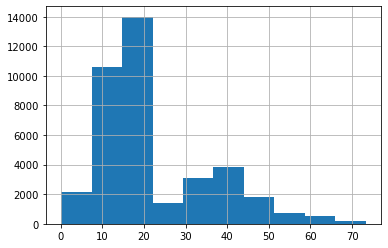

In [11]:
network['C_SPEED'].hist()

<AxesSubplot:>

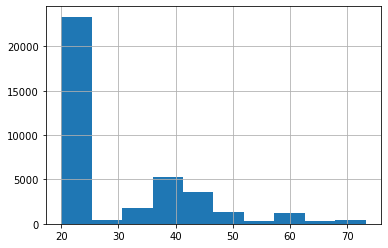

In [12]:
network['FFSPEED'].hist()

#### Process Ridership Variables

C:\Anaconda3\envs\stops_geo\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


<AxesSubplot:>

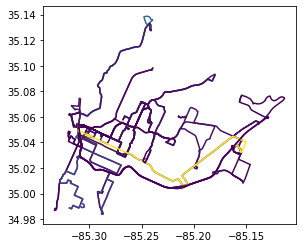

In [13]:
route_boards = boards.copy()

##  17. Map: Transit Route Ridership (graduated color and bandwidth)
route_boards = boards.groupby(['ROUTE_ID', 'ROUTE_NAME'])['AM_ON', 'PM_ON', 'OP_ON'].sum().reset_index()
route_boards = route_boards.astype(dtypes)
route_boards['BOARDINGS'] =(route_boards['AM_ON'] + route_boards['PM_ON'] + route_boards['OP_ON']).astype(int)

route_boards = pd.merge(routes, route_boards[['ROUTE_ID', 'BOARDINGS']], on='ROUTE_ID', how='left')
route_boards = route_boards.astype(dtypes)
route_boards = pd.merge(route_boards, ref[['ROUTE_ID', 'Route', 'Long Name']], on='ROUTE_ID', how='left')
route_boards['Route_Name'] = route_boards['Route'] + ': ' + route_boards['Long Name']
# route_boards = route_boards.groupby(['Route', 'Long Name'])['BOARDINGS'].sum().astype(int).reset_index()

route_boards.plot('BOARDINGS')

#### Process Trips Variables

In [14]:
xref = pd.read_csv(xref_path)
xref = xref[['TAZID', 'TAZ_Ext']].copy()

C:\Anaconda3\envs\stops_geo\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Anaconda3\envs\stops_geo\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<AxesSubplot:>

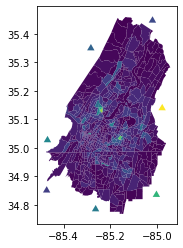

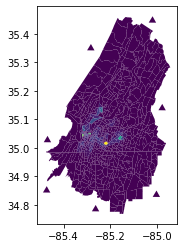

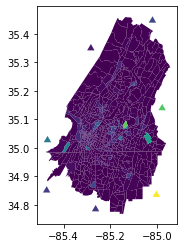

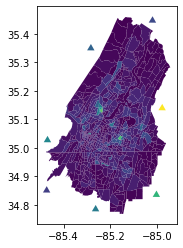

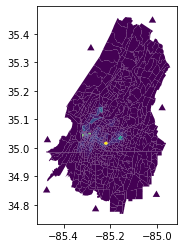

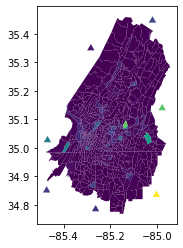

In [15]:
tazcol = 'TAZ_Ext'
taz_trips = taz.copy()

## ORIGIN
##  18. Map: Origin of Passenger Vehicle Trips by TAZ (graduated color)
trips = tt['trip_tables'].groupby('Origin')['PASS'].sum().reset_index()
trips.columns = ['TAZID', 'O_PASS']

trips = pd.merge(trips, xref, on='TAZID', how='left')
trips = trips.groupby('TAZ_Ext')['O_PASS'].sum().reset_index()

taz_trips = pd.merge(taz_trips, trips, on=tazcol, how='left')
taz_trips.plot('O_PASS')


##  19. Map: Origin of Transit Trips by TAZ (graduated color)
trips = pd.concat([tt[f'tranist_trip_tables_{t}'] for t in ['AM', 'PM', 'OP']])[['Origin', 'Local']]
trips = trips.fillna(0).groupby('Origin').sum().reset_index()
trips.columns = ['TAZID', 'O_TRANSIT']

trips = pd.merge(trips, xref, on='TAZID', how='left')
trips = trips.groupby('TAZ_Ext')['O_TRANSIT'].sum().reset_index()

taz_trips = pd.merge(taz_trips, trips, on=tazcol, how='left')
taz_trips.plot('O_TRANSIT')

##  20. Map: Origin of Truck Trips by TAZ (graduated color)
trips = tt['Truck_OD'].groupby("Row ID's")['Total_SUT', 'Total_MUT'].sum().reset_index()
trips['TRUCKS'] = trips['Total_SUT'] + trips['Total_MUT']
trips = trips[["Row ID's", 'TRUCKS']]
trips.columns = ['TAZID', 'O_TRUCKS']

trips = pd.merge(trips, xref, on='TAZID', how='left')
trips = trips.groupby('TAZ_Ext')['O_TRUCKS'].sum().reset_index()

taz_trips = pd.merge(taz_trips, trips, on=tazcol, how='left')
taz_trips.plot('O_TRUCKS')

## DESTINATION
##  21. Map: Destination of Passenger Vehicle Trips by TAZ (graduated color)
trips = tt['trip_tables'].groupby('Destination')['PASS'].sum().reset_index()
trips.columns = ['TAZID', 'D_PASS']

trips = pd.merge(trips, xref, on='TAZID', how='left')
trips = trips.groupby('TAZ_Ext')['D_PASS'].sum().reset_index()

taz_trips = pd.merge(taz_trips, trips, on=tazcol, how='left')
taz_trips.plot('D_PASS')

##  22. Map: Destination of Transit Trips by TAZ (graduated color)
trips = pd.concat([tt[f'tranist_trip_tables_{t}'] for t in ['AM', 'PM', 'OP']])[['Destination', 'Local']]
trips = trips.fillna(0).groupby('Destination').sum().reset_index()
trips.columns = ['TAZID', 'D_TRANSIT']

trips = pd.merge(trips, xref, on='TAZID', how='left')
trips = trips.groupby('TAZ_Ext')['D_TRANSIT'].sum().reset_index()

taz_trips = pd.merge(taz_trips, trips, on=tazcol, how='left')
taz_trips.plot('D_TRANSIT')

##  23. Map: Destination of Truck Trips by TAZ (graduated color)
trips = tt['Truck_OD'].groupby("Col ID's")['Total_SUT', 'Total_MUT'].sum().reset_index()
trips['TRUCKS'] = trips['Total_SUT'] + trips['Total_MUT']
trips = trips[["Col ID's", 'TRUCKS']]
trips.columns = ['TAZID', 'D_TRUCKS']

trips = pd.merge(trips, xref, on='TAZID', how='left')
trips = trips.groupby('TAZ_Ext')['D_TRUCKS'].sum().reset_index()

taz_trips = pd.merge(taz_trips, trips, on=tazcol, how='left')
taz_trips.plot('D_TRUCKS')

### Checks

In [16]:
network[['AM_LOS', 'PM_LOS', 'FFSPEED', 'VMT', 'VHD', 'C_SPEED']].describe()

,AM_LOS,PM_LOS,FFSPEED,VMT,VHD,C_SPEED
count,38293.000000,38293.000000,38293.000000,38293.000000,38293.000000,38293.000000
mean,0.046411,0.058578,29.490134,362.665669,2.720654,21.987459
std,0.104490,0.125604,13.140606,1927.572616,18.600309,13.300754
min,0.000000,0.000000,20.000000,0.000000,-0.000040,0.157996
25%,0.000000,0.000000,20.000000,0.000000,0.000000,13.438267
50%,0.000000,0.000000,20.000000,0.000000,0.000000,17.078939
75%,0.025293,0.035678,39.659496,120.182963,0.017003,30.849745
max,1.116131,1.162090,73.250000,102236.249752,876.776432,73.250013


### Export Datasets

#### Network

In [17]:
network.to_file(network_save_path,
           index=False
          )

#### Ridership

In [18]:
route_boards.to_file(routes_save_path,
           index=False
          )

#### Trips

In [19]:
taz_trips.to_file(trips_save_path,
           index=False
          )